In [1]:
!pip install tensorflow matplotlib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
!pip install opencv-python-headless


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

Reading package lists... Done
E: List directory /var/lib/apt/lists/partial is missing. - Acquire (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [4]:
import tensorflow as tf
%matplotlib inline
import os
import cv2

2024-12-02 09:47:47.082527: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733132867.097305   15859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733132867.101802   15859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 09:47:47.118422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


이미지 파일의 확장자를 읽어내고 문제가 있는 파일을 삭제하는 코드

In [5]:
import imghdr

/tmp/ipykernel_15859/336752527.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = './datasets/fire_dataset'

image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

이미지 데이터 전처리

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt


Found 992 files belonging to 2 classes.


2024-12-02 09:47:59.615620: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


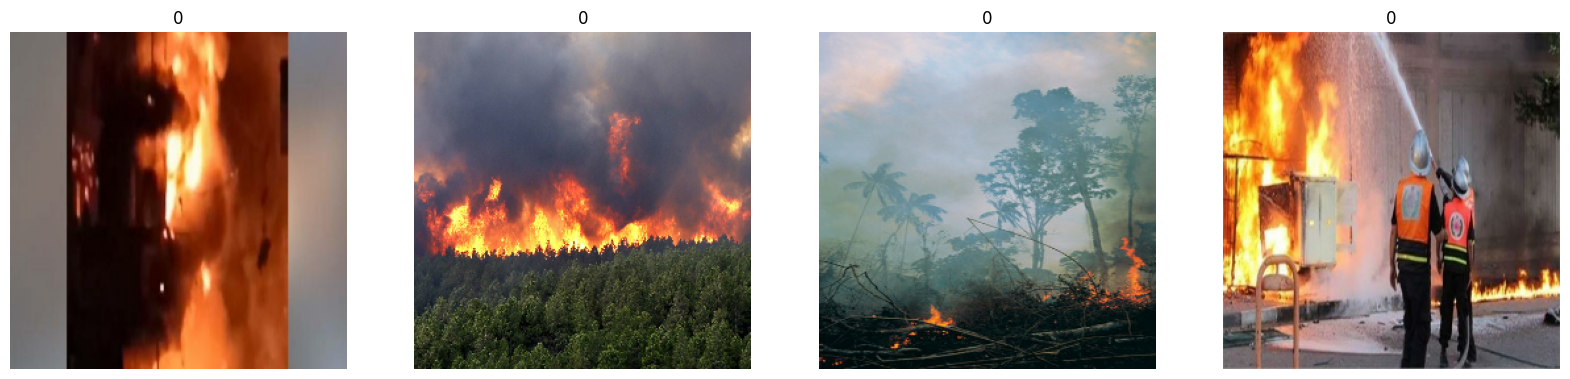

In [8]:
data = tf.keras.utils.image_dataset_from_directory('./datasets/fire_dataset')

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')
plt.show()

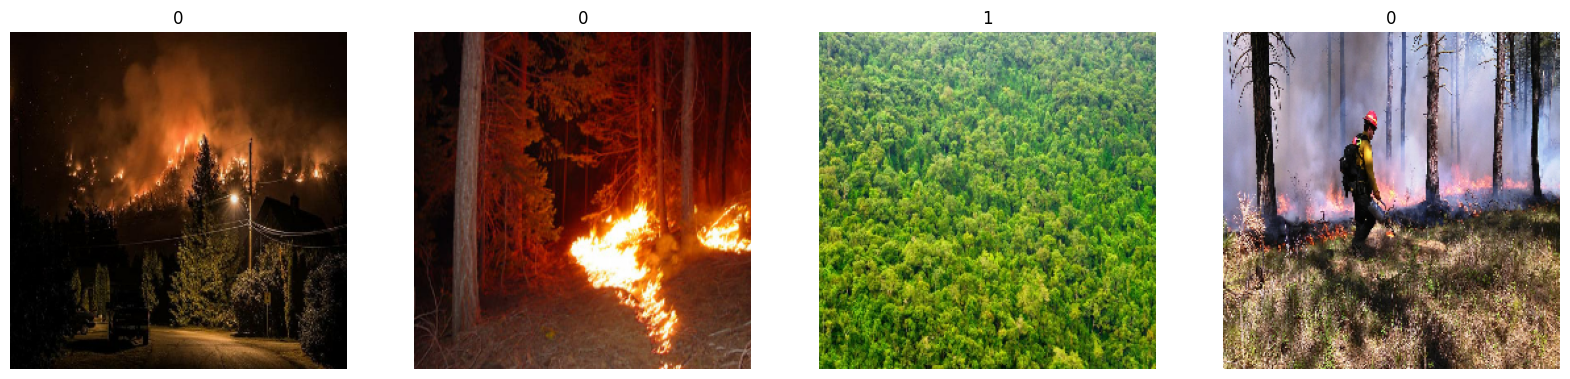

In [9]:
data = data.map(lambda x,y: (x/255, y)) #데이터 정규화

batch = data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
    ax[idx].axis('off')

In [10]:
#데이터 셋 분할
train_size = int(len(data)*.7) + 1
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

모델

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - accuracy: 0.7163 - loss: 0.8223 - val_accuracy: 0.8854 - val_loss: 0.2199
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 770ms/step - accuracy: 0.9308 - loss: 0.1784 - val_accuracy: 0.9531 - val_loss: 0.1007
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.9566 - loss: 0.1076 - val_accuracy: 0.9635 - val_loss: 0.0987
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 779ms/step - accuracy: 0.9658 - loss: 0.0951 - val_accuracy: 0.9792 - val_loss: 0.0821
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 803ms/step - accuracy: 0.9621 - loss: 0.1312 - val_accuracy: 0.9688 - val_loss: 0.0753
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 778ms/step - accuracy: 0.9475 - loss: 0.1404 - val_accuracy: 0.9792 - val_loss: 0.0846
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 827ms/step - accuracy: 0.9713 - loss: 0.0816 - val_accuracy: 0.9740 - val_loss: 0.0634
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 782ms/step - accuracy: 0.9865 - loss: 0.0456 - val_accu

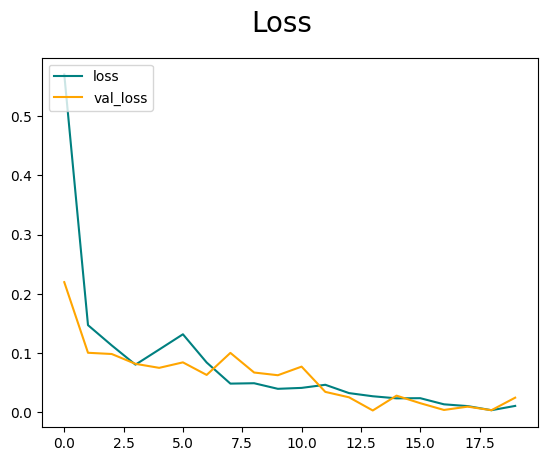

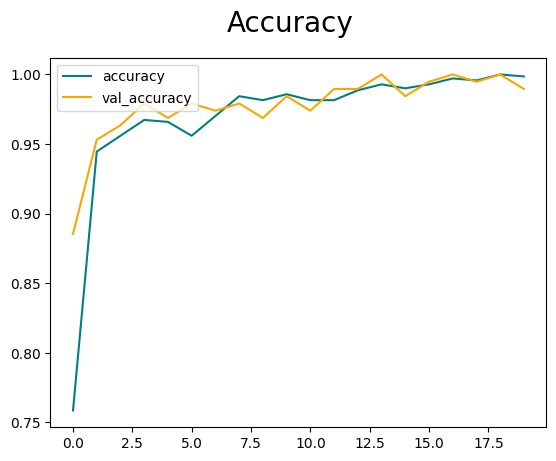

In [14]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

모델 평가

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print('precision: {}'.format(pre.result()))
print('recall: {}'.format(re.result()))
print('accuracy: {}'.format(acc.result()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
precision: 1.0
recall: 1.0
accuracy: 1.0


2024-12-02 09:54:12.396381: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


2024-12-02 09:54:15.946761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


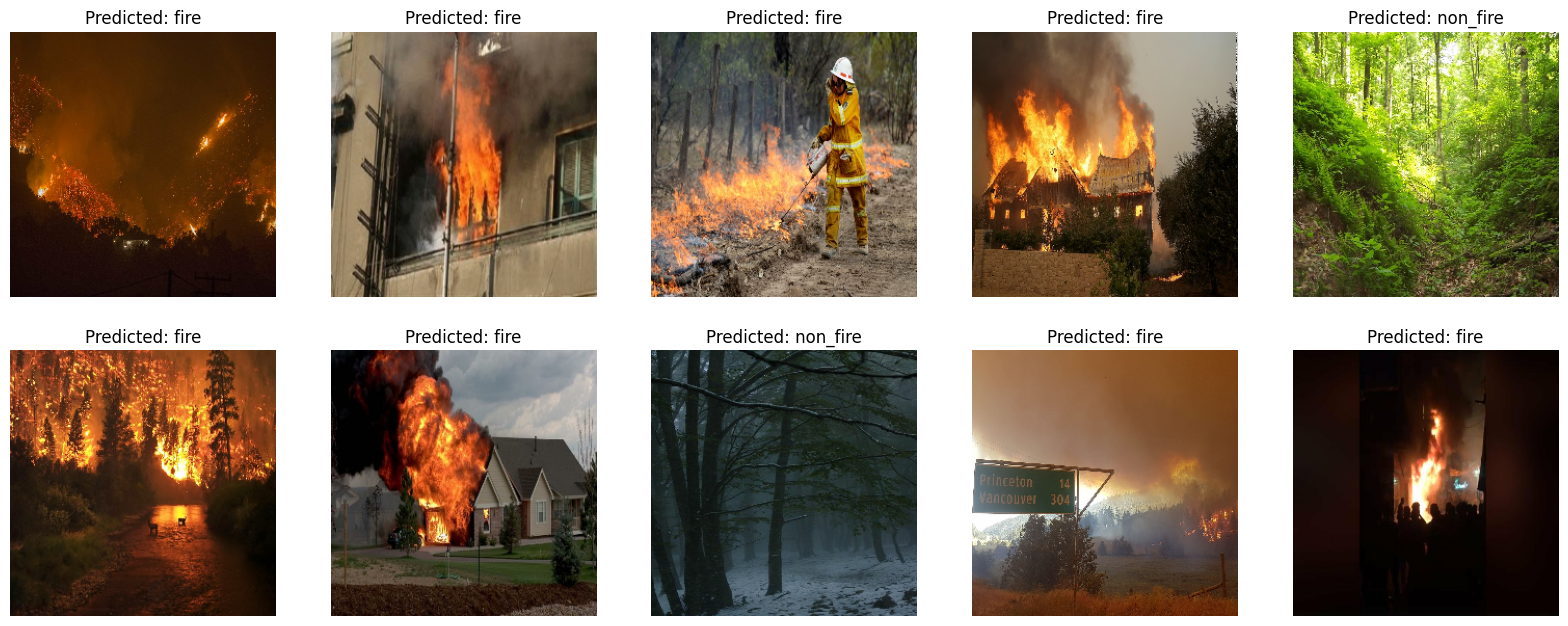

In [16]:
for images, labels in test.take(1):
    test_images = images[:10]
    test_labels = labels[:10]

predictions = model.predict(test_images)

def get_label_name(pred):
    return 'fire' if pred < 0.5 else 'non_fire'

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"Predicted: {get_label_name(predictions[i])}")
    plt.axis('off')
plt.show()